In [20]:
import sys
sys.path.append('../')

import thermonets as tn
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

### 1 - Load the model

In [21]:

# Here we create the model, which must be identical to the one loaded
model = tn.ffnn(input_dim=10,
                        hidden_layer_dims=[32, 32],
                        output_dim=12,
                        mid_activation=torch.nn.Tanh(),
                        last_activation=torch.nn.Tanh())
model_path = "../models/nrlmsise00_model_10_32_32_3.73.pyt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### 2 - Load the dataset

In [22]:

# Here we the db the model was trained upon.
#note that columns can be (len 16):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'wind zonal [m/s]', 'wind meridional [m/s]', 'density [kg/m^3]'
#or (len 14):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'density [kg/m^3]'
db=np.loadtxt('../dbs/nrlmsise00_db.txt',delimiter=',',skiprows=1)
np.random.shuffle(db)

with open('../global_fits/global_fit_nrlmsise00_180.0-1000.0-4.txt','rb') as f:
    best_global_fit=torch.from_numpy(pickle.load(f))
    
print(f'Shape of database is: {db.shape}')
print(f"Best fit has length: {len(best_global_fit)}")

Shape of database is: (999700, 14)
Best fit has length: 12


### 3 - Extract from the dataset all attributes
These include the quantities to be fed to the network as well as some auxiliary ones that are necessary to compute $\rho$

In [23]:
# Renames some of the db content with readable names
days=db[:,0]
months=db[:,1]
years=db[:,2]
hours=db[:,3]
minutes=db[:,4]
seconds=db[:,5]
microseconds=db[:,6]
alt=db[:,7]
# Geodetic longitude and latitude are converted in radians:
lat=np.deg2rad(db[:,8])
lon=np.deg2rad(db[:,9])
# Space weather indices:
f107a=db[:,10]
f107=db[:,11]
ap=db[:,12]
# Atmospheric density as well:
target_density=db[:,-1]

# We need to extract from the db also the doy (Day of Year) and the sid (seconds in day)
seconds_in_day=hours*3600+minutes*60+seconds+microseconds/1e6
print('seconds in day min and max:')
print(seconds_in_day.min(), seconds_in_day.max())
doys=np.zeros(db.shape[0])
for i in range(len(db)):
    #date is a string, so I first convert it to datetime:
    date_=datetime.datetime(year=int(years[i]), 
                            month=int(months[i]), 
                            day=int(days[i]),
                            hour=int(hours[i]),
                            minute=int(minutes[i]),
                            second=int(seconds[i]),
                            microsecond=int(microseconds[i]))
    doys[i]=date_.timetuple().tm_yday
print('day of the year min and max:')
print(doys.min(), doys.max())

seconds in day min and max:
20.64977 86392.51835
day of the year min and max:
1.0 365.0


In [24]:
db_processed=np.zeros((db.shape[0],13))
db_processed[:,0]=np.sin(lon)
db_processed[:,1]=np.cos(lon)
db_processed[:,2]=np.sin(lat)
db_processed[:,3]=np.sin(2*np.pi*seconds_in_day/86400.)
db_processed[:,4]=np.cos(2*np.pi*seconds_in_day/86400.)
db_processed[:,5]=np.sin(2*np.pi*doys/365.25)
db_processed[:,6]=np.cos(2*np.pi*doys/365.25)
db_processed[:,7]=tn.normalize_min_max(f107, 60., 266.)
db_processed[:,8]=tn.normalize_min_max(f107a, 60., 266.)
db_processed[:,9]=tn.normalize_min_max(ap, 0., 110.)
db_processed[:,10]=tn.normalize_min_max(alt, 170., 1010.)

#Add the non-normalized density & altitude columns (useful to extract during training):
db_processed[:,11]= alt
db_processed[:,12]= target_density

# Cross check that the max is <=1 and the min is >=-1
print(f"maximum and minimum of all the normalized data: {db_processed[:,7:11].max()}, {db_processed[:,7:11].min()}")
print(f"maximum and minimum of target density: {target_density.max()}, {target_density.min()}")

maximum and minimum of all the normalized data: 0.9761904761904763, -1.0
maximum and minimum of target density: 7.20569529348575e-10, 1.9693989513886182e-16


### 4 - Plots of the errors using the db entries

In [25]:
# We move the db into a torch array
db_processed_torch = torch.tensor(db_processed, dtype=torch.float32)
# Compute the parameters of the exponentials as params_i = params_i0 (1 + NNout_i)
delta_params = model(db_processed_torch[:,:-3])
params = best_global_fit*(1+delta_params)
# Compute the inference of the model over the entire dataset
predicted = tn.rho_approximation(db_processed_torch[:,-2], params, backend="torch")
true = db_processed_torch[:,-1]

In [26]:
rel_err = ((predicted - true) / true).detach() * 100
torch.mean(torch.abs(rel_err))

tensor(3.8080)

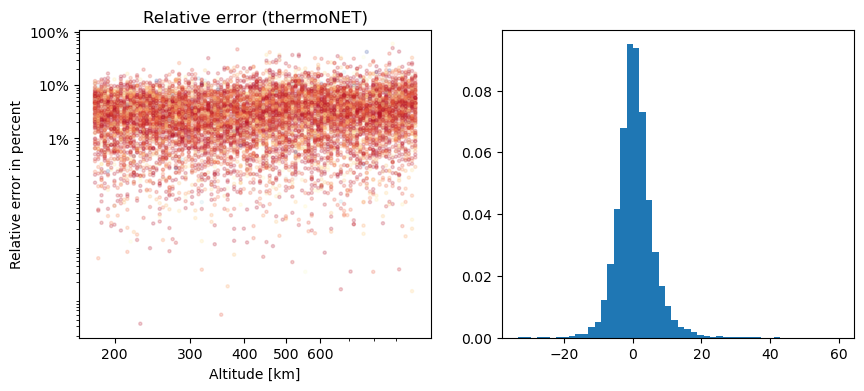

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
cm = plt.colormaps['RdYlBu']

rel_err = ((predicted - true) / true).detach() * 100

c = (db_processed_torch[::99,7]+1)/2
sc = ax[0].scatter(db_processed_torch[::99, 11], torch.abs(rel_err[::99]), alpha=0.2, c=c, s=5, cmap=cm)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("Relative error (thermoNET)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Relative error in percent")


#
ax[1].hist(rel_err[::99], bins = 50, density=True);